In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
from torchvision import datasets
datasets.MNIST.resources = [
            ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz', 'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz', 'd53e105ee54ea40749a09fcbcd1e9432'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz', '9fb629c4189551a2d022fa330f9573f3'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz', 'ec29112dd5afa0611ce80d1b7f02629c')
        ]

In [3]:
transform = transforms.ToTensor()

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
dataiter = iter(dataloader)
images,labels = dataiter.next()
print(torch.min(images),torch.max(images))

tensor(0.) tensor(1.)


In [7]:
class autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    #N,784
    self.encoder = nn.Sequential(
        nn.Linear(28*28,196), # N,784
        nn.ReLU(),
        nn.Linear(196,49),
        nn.ReLU(),
        nn.Linear(49,16),
    )
    self.decoder = nn.Sequential(
        nn.Linear(16,49),
        nn.ReLU(),
        nn.Linear(49,196),
        nn.ReLU(),
        nn.Linear(196,28*28),
        nn.Sigmoid()
    )
    
  def forward(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

model = autoencoder()
print(model)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=196, bias=True)
    (1): ReLU()
    (2): Linear(in_features=196, out_features=49, bias=True)
    (3): ReLU()
    (4): Linear(in_features=49, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=49, bias=True)
    (1): ReLU()
    (2): Linear(in_features=49, out_features=196, bias=True)
    (3): ReLU()
    (4): Linear(in_features=196, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [9]:
from torchsummary import summary
summary(model,(1,784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 196]         153,860
              ReLU-2               [-1, 1, 196]               0
            Linear-3                [-1, 1, 49]           9,653
              ReLU-4                [-1, 1, 49]               0
            Linear-5                [-1, 1, 16]             800
            Linear-6                [-1, 1, 49]             833
              ReLU-7                [-1, 1, 49]               0
            Linear-8               [-1, 1, 196]           9,800
              ReLU-9               [-1, 1, 196]               0
           Linear-10               [-1, 1, 784]         154,448
          Sigmoid-11               [-1, 1, 784]               0
Total params: 329,394
Trainable params: 329,394
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-3)

In [16]:
n_epoch = 20
outputs = []
for epoch in range(1, n_epoch+1):
  for(image,label) in dataloader:
    image = image.reshape(-1,28*28)
    output_img = model(image)
    loss = criterion(output_img,image)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch,loss))
  outputs.append((epoch, image, output_img))




Epoch: 1 	Training Loss: 0.014963
Epoch: 2 	Training Loss: 0.014231
Epoch: 3 	Training Loss: 0.013686
Epoch: 4 	Training Loss: 0.013159
Epoch: 5 	Training Loss: 0.012794
Epoch: 6 	Training Loss: 0.012537
Epoch: 7 	Training Loss: 0.012266
Epoch: 8 	Training Loss: 0.012061
Epoch: 9 	Training Loss: 0.011826
Epoch: 10 	Training Loss: 0.011610
Epoch: 11 	Training Loss: 0.011409
Epoch: 12 	Training Loss: 0.011215
Epoch: 13 	Training Loss: 0.010980
Epoch: 14 	Training Loss: 0.010817
Epoch: 15 	Training Loss: 0.010674
Epoch: 16 	Training Loss: 0.010511
Epoch: 17 	Training Loss: 0.010416
Epoch: 18 	Training Loss: 0.010367
Epoch: 19 	Training Loss: 0.010318
Epoch: 20 	Training Loss: 0.010291


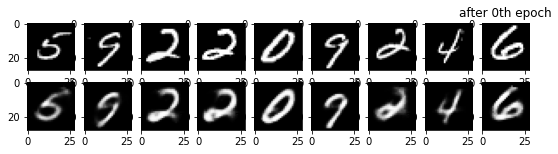

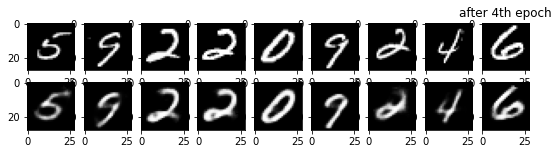

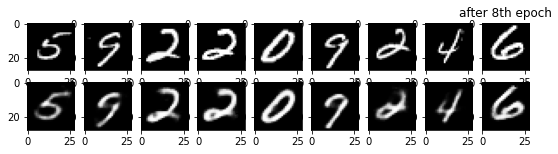

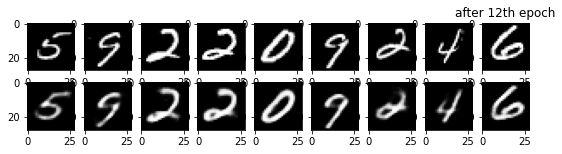

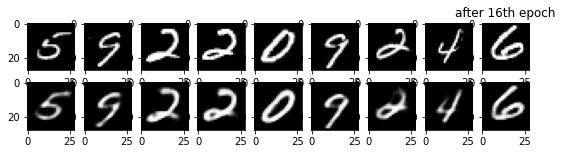

In [26]:
for k in range(0,n_epoch,4):
  plt.figure(figsize=(9,2))
  plt.gray()
  #print(k)
  imgs = outputs[k][1].detach().numpy()
  recons = outputs[k][2].detach().numpy()

  for i,item in enumerate(imgs):
    if i>=9: break
    plt.subplot(2,9,i+1)
    item = item.reshape(-1,28,28)
    plt.imshow(item[0])
  plt.title("after "+ str(k)+ "th epoch")

  for i,item in enumerate(recons):
    if i>=9: break
    plt.subplot(2,9,9+i+1)
    item = item.reshape(-1,28,28)
    plt.imshow(item[0])
